# <center> Escuela de ML y DL Módulo 1 </center> 
##  <center> Tarea 4. K-medoids </center>
##  <center> Arnoldo Fernando Chue Sánchez </center>
##  <center> arnoldwork20@gmail.com </center>
##  <center> Abril de 2024 </center>

## Contenido 
1. Planteamiento del problema
2. Planteamiento de la solución
    * Preprocesamiento de los datos
        * Preparar los datos
        * Limpieza de los datos
        * Creación del dataframe para el modelo no supervisado
        * Estandarización y normalización de los datos
    * Creación de los modelos vistos en la sesión con Kmeans
    * Creación de los modelos con Kmedoids
    * Guardamos los modelos
3. Comparación de los modelos
    * Analizando con la inercia y silhouette de los modelos
    * Analizando con las gráficas de los resultados
4. Conclusiones 
5. Referencias

# 1. Planteamiento del problema

*Haciendo uso de la práctica 4 y el dataset que se mostró en clase, también disponible en https://www.kaggle.com/hellbuoy/online-retail-customer-clustering haga lo siguiente:*

* *Construya un modelo K-medoids para hacer clustering igual a lo visto en la sesión.* 
* *Obtenga las métricas de inercia y silhouette.*
* *Haga el análisis comparativo entre ambos modelos.*
* *Documente sus resultados (añada gráficas).*

# 2. Planteamiento de la solución

## Preprocesamiento de los datos

Comenzamos con el preprocesamiento de los datos. Este procedimiento lo haremos igual que en la práctica 4 porque necesitamos formar el mismo dataset.

### Preparar los datos

Cargamos los módulos que vamos a necesitar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import kmedoids
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
PATH = "./datasets/"

In [3]:
o_retail = pd.read_csv(PATH + "OnlineRetail.csv", encoding="ISO-8859-1")

In [4]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
o_retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Limpieza de los datos

Como se mecionó con anterioridad, vamos a limpiar los datos exactamente igual que en la práctica para garantizar tener los mismos resultados en los modelos con Kmeans y posteriormente evaluar objetivamente los modelos con Kmedoids

In [6]:
o_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Rellenamos los datos nulos en el ID del cliente

In [4]:
o_retail["CustomerID"] = o_retail["CustomerID"].fillna(0)

Eliminamos el resto de los datos nulos (son un poco más de 1500) en la descripción del producto

In [5]:
o_retail.dropna(inplace=True)

In [9]:
o_retail.describe()

,Quantity,UnitPrice,CustomerID
count,540455.000000,540455.000000,540455.000000
mean,9.603129,4.623519,11507.851471
std,218.007598,96.889628,6760.792031
min,-80995.000000,-11062.060000,0.000000
25%,1.000000,1.250000,12367.000000
50%,3.000000,2.080000,14390.000000
75%,10.000000,4.130000,16261.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
o_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   CustomerID   540455 non-null  float64
 7   Country      540455 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.1+ MB


Vemos la cantidad de valores únicos por cada columna

In [11]:
for i in o_retail: print(i, o_retail[i].nunique())

InvoiceNo 24446
StockCode 3958
Description 4223
Quantity 671
InvoiceDate 22309
UnitPrice 1630
CustomerID 4373
Country 38


Manejamos los datos negativos (que faltan por entregar) de la cantidad de productos vendidos al cliente

In [6]:
def status(quantity):
    if quantity < 0:
        quantity = quantity*(-1)
        return 0
    return 1

In [7]:
o_retail["Status"] = o_retail.apply(lambda Row: status(Row["Quantity"]), axis=1)

In [14]:
o_retail["Status"].value_counts()

Status
1    530693
0      9762
Name: count, dtype: int64

Cambiamos el tipo de dato del ID del cliente a str

In [9]:
o_retail["CustomerID"] = o_retail["CustomerID"].astype(str)

Agregamos la columna del monto total

In [10]:
o_retail["AmountTotal"] = o_retail["Quantity"] * o_retail["UnitPrice"]

In [17]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,AmountTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,1,20.34


Damos el formato a la columna InvoiceDate (fecha de factura) para que sea datetype

In [11]:
o_retail["InvoiceDate"] = pd.to_datetime(o_retail["InvoiceDate"], format="%d-%m-%Y %H:%M")

Creamos una columna para mostrar la última actividad de cada cliente, con respecto a la fecha más reciente del dataset

In [12]:
dateMax = o_retail["InvoiceDate"].max()
o_retail["LastInvoice"] = dateMax - o_retail["InvoiceDate"]
o_retail["LastInvoice"] = o_retail["LastInvoice"].dt.days

In [20]:
o_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,AmountTotal,LastInvoice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,20.34,373


Con esto ya quedó limpio y preparado el dataframe

### Creación del dataframe para el modelo no supervisado 

Del modelo que hemos creado, vamos a crear otro dataframe para nuestros modelos no supervisados para hacer clustering. Este nuevo dataframe va a agrugar por cliente, es decir, por CustomerID. Para esta agrupación va a mostrar la cantidad de facturas realizadas (InvoiceNo), el total del dinero pagado (suma de AmountTotal) y la última vez que compró (el mínimo de la cantidad de días desde su última compra: LastInvoice)

In [13]:
invoice = pd.DataFrame(o_retail.groupby('CustomerID')['InvoiceNo'].count())
amountT = pd.DataFrame(o_retail.groupby('CustomerID')['AmountTotal'].sum())
lastI = pd.DataFrame(o_retail.groupby('CustomerID')['LastInvoice'].min())

In [14]:
new_retail = pd.concat([invoice, amountT, lastI], axis=1)

In [23]:
new_retail.head()

,InvoiceNo,AmountTotal,LastInvoice
CustomerID,,,
0.0,133626,1447682.12,0
12346.0,2,0.00,325
12347.0,182,4310.00,1
12348.0,31,1797.24,74
12349.0,73,1757.55,18


Este será el conjunto de datos con el que vamos a entrenar nuestros modelos. Recordemos que por ser no supervisados no tenemos clases para el vector de etiquetas Y.

### Estandarización y normalización de los datos

Vamos a escalar el modelo para tener dos conjuntos: uno estandarizado y otro normalizado.

In [15]:
scaler = MinMaxScaler()
scalerSS = StandardScaler()

Vamos a reutilizar la función que usamos en la sesión para escalar los dataframes

In [16]:
def escalar(df, scal):
    ind = df.index
    retail_scaler = pd.DataFrame(scal.fit_transform(df), index=ind)
    retail_scaler.columns = df.columns
    return retail_scaler, scal

In [17]:
df_MMS, scaler = escalar(new_retail, scaler)
df_SS, scalerSS = escalar(new_retail, scalerSS)

In [27]:
df_MMS.head()

,InvoiceNo,AmountTotal,LastInvoice
CustomerID,,,
0.0,1.000000,1.000000,0.000000
12346.0,0.000007,0.002953,0.871314
12347.0,0.001355,0.005921,0.002681
12348.0,0.000225,0.004191,0.198391
12349.0,0.000539,0.004163,0.048257


In [28]:
df_SS.head()

,InvoiceNo,AmountTotal,LastInvoice
CustomerID,,,
0.0,65.687327,61.892754,-0.903471
12346.0,-0.059826,-0.095447,2.322278
12347.0,0.028740,0.089103,-0.893545
12348.0,-0.045557,-0.018491,-0.168992
12349.0,-0.024891,-0.020190,-0.724814


Desde aquí se puede ver que ambos conjuntos quedaron con valores diferentes. Esto naturalmente produce modelos diferentes al hacer su entrenamiento (aunque sea con el mismo algoritmo)

## Creación de los modelos vistos en la sesión con Kmeans

Vamos a crear los modelos con Kmeans. Recordemos que en Kmeans ajustamos el modelo con base en la media de las distancias de los datos a los centroides de los clusters a los que pertenecen. Por lo tanto, la cantidad de clusters es clave para ver qué tan definidos quedan. (Recordemos que esto lo podemos medir con métricas como la inercia y silhouette).

Ahora bien, tenemos que encontrar el equilibrio al momento de escoger la k. Porque si bien entre mayor sea la k, más definidos son los clusters (mejoramos las métricas), también el tiempo de cómputo para los cálculos se incrementa. Además, podríamos llegar a sobreajustar el modelo: perdemos la generalidad de la agrupación de nuestros registros.

Por lo tanto, vamos a construir los modelos con las k óptimas que encontramos en la práctica durante la sesión, tanto para los datos estandarizados, como para los normalizados.

En ese orden de ideas, la k para el conjunto estandarizado es de 8 y para el normalizado es de 5.

In [25]:
kmeansMMSK = KMeans(n_clusters=5, init='k-means++')
kmeansSSK = KMeans(n_clusters=8, init='k-means++')

Usemos la función que teníamos en la práctica para realizar las predicciones del agrupamiento. Esto nos servirá para medir el desempeño del modelo con las métricas de inercia y silhouette.

In [19]:
def prediccion(df, model):
    model.fit(df)
    print(model.predict(df))
    print("Inercia = ", model.inertia_)
    pred = model.predict(df)
    return pred

In [26]:
predMMSK = prediccion(df_MMS, kmeansMMSK)

[4 2 4 ... 4 4 0]
Inercia =  13.021125069934222


In [27]:
predSSK = prediccion(df_SS, kmeansSSK)

[2 7 1 ... 1 1 1]
Inercia =  284.8147540850684


Veamos su Silhouette de ambos modelos

In [28]:
silhoutte_MMSK = silhouette_score(df_MMS, kmeansMMSK.labels_, metric='euclidean')
print("Silhouette =", silhoutte_MMSK)

Silhouette = 0.6117605145697713


In [29]:
silhoutte_SSK = silhouette_score(df_SS, kmeansSSK.labels_, metric='euclidean')
print("Silhouette =", silhoutte_SSK)

Silhouette = 0.5539630021974014


Comparando las métricas obtenidas con las de la sesión, se pueden ver algunas diferencias. Aunque sí son ligeramente diferentes, no son tan significativas como para cambiar los modelos. Por lo tanto, podemos confiar en que sí replicamos los modelos de la sesión correctamente.

Nada más para confirmar que estos valores para las k son los óptimos, usaremos la función de la sesión que grafica el desempeño de las k.

In [30]:
def buscar_k(df):
    SSE = []
    for cluster in range(1,20):
        kmeans = KMeans(n_clusters = cluster, init='k-means++')
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)
    porc = 1
    for i in range(len(SSE)-1):
        dif = (SSE[i] - SSE[i+1])
        print('Punto',i+1,'a',i+2, dif/porc) 
        porc = dif
    plt.plot(range(1,20), SSE, 'o-')

Punto 1 a 2 253.49994123698542
Punto 2 a 3 0.13637663174478434
Punto 3 a 4 0.38696580921536905
Punto 4 a 5 0.5029766580830703
Punto 5 a 6 0.4356519552308592
Punto 6 a 7 0.6661565951247435
Punto 7 a 8 0.70087609125559
Punto 8 a 9 1.659282164793133
Punto 9 a 10 0.44851829465443044
Punto 10 a 11 0.6816080067299313
Punto 11 a 12 0.7440050097915137
Punto 12 a 13 0.6261474528665486
Punto 13 a 14 0.5261458847404322
Punto 14 a 15 2.2302899142284938
Punto 15 a 16 0.3203311944266295
Punto 16 a 17 1.2696767361478496
Punto 17 a 18 -0.030812326591300968
Punto 18 a 19 -16.808011757858374


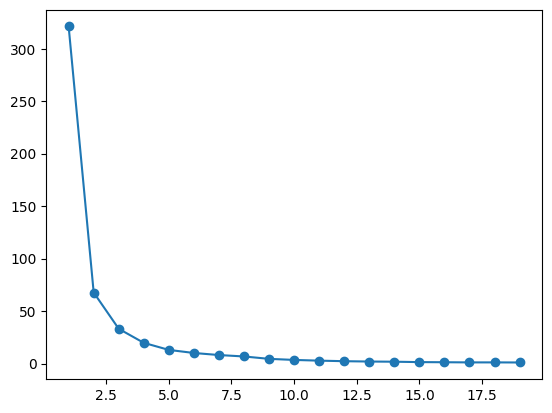

In [31]:
buscar_k(df_MMS)

Punto 1 a 2 8148.217589801072
Punto 2 a 3 0.42715276558604154
Punto 3 a 4 0.1367428508805759
Punto 4 a 5 0.3972813880964508
Punto 5 a 6 1.8902367765483297
Punto 6 a 7 0.25993914161739
Punto 7 a 8 1.0816587840927971
Punto 8 a 9 0.32992211781423847
Punto 9 a 10 1.1479292882087788
Punto 10 a 11 0.7282077619959172
Punto 11 a 12 0.7678622243563095
Punto 12 a 13 0.9531932780474
Punto 13 a 14 0.9266862827308036
Punto 14 a 15 0.4602203972287561
Punto 15 a 16 0.9919716812619795
Punto 16 a 17 1.2650796487838762
Punto 17 a 18 0.6861635395519993
Punto 18 a 19 1.4560063635137397


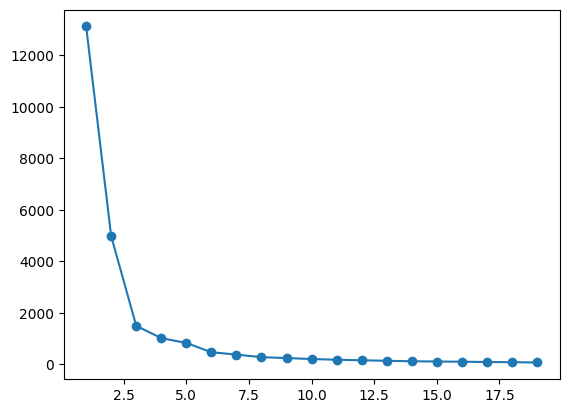

In [32]:
buscar_k(df_SS)

Confirmamos entonces que nuestras k son las óptimas

## Creación de los modelos con Kmedoids

Ahora creamos los modelos con KMedoids. Para entender cómo trabaja este algoritmo, vamos a retomar las ideas de Kmeans porque funcionan muy similar:
1. En un inicio Kmeans toma puntos aleatorios para hacerlos los centroides de nuestros clusters. Por otro lado, KMedoids lo que hace es tomar aleatoriamente puntos de los datos y los usará como centroides, es decir, los centroides no son puntos generados sino puntos de nuestros datos.
2. A continuación a todos los puntos se les asigna a su cluster más cercano con una métrica de distancia. Este paso funciona igual para ambos algoritmos.
3. En este paso lo que se hace es buscar optimizar nuestras agrupaciones lo mejor posible.
    - En KMeans lo que hacíamos era calcular el punto promedio de todos los puntos del cluster y ese punto promedio es el nuevo centroide. A partir de aquí se repiten los pasos 2 y 3 hasta alcanzar un criterio para detener el algoritmo (máximo número de iteraciones, convergencia, etc)
    - En KMedoids lo que se hace es escoger un punto diferente al centroide dentro de su cluster. Este nuevo punto debe estar lo más en el centro posible. Aquí se repite el paso 2 (asignación de los puntos a su agrupación) y se calculan las nuevas distancias de los puntos al centroide. Si estas suma de distancia es menor a la del anterior centroide continuamos optimizando. Si no se puede optimizar más terminamos esta iteración por los puntos de los datos donde cada uno puede llegar a ser el centroide.

Aquí podemos ver algunos aspectos importantes del KMedoids: 
- Es más robusto que el KMeans porque es menos probable que lo afecten los outliers. Al KMeans lo afectan porque mueven la posición del centroide al sacar el promedio de los puntos. Mientras que a KMedoids simplemente no lo afectan porque si llegan a ser los centroides simplemente a la siguiete iteración los optimizarán.
- Al ser más robusto también es más costoso computacionalmente hablando. Para grandes conjuntos de datos va a tardar en entrenar el modelo. Esto se debe a la naturaleza combinatoria del algoritmo: cada punto de los datos puede ser un centroide. Entonces entre más k tenemos, más combinaciones de datos pueden formar esos k centroides.

Tomando esto en consideración, considero que es mejor idea buscar directamente la K óptima para ambos conjuntos de datos para ahorrar tiempo de estar experimentando con la k. Adaptemos entonces la función buscar_k para usarla con los modelos de kmedois y obtener la k con la regla del codo.

In [37]:
def buscar_k_para_kmedoids(df, k_test):
    SSE = []
    # Vamos a reducir las pruebas para k muy grandes para reducir el tiempo de cómputo
    for cluster in range(1,k_test):
        # Aquí es donde tenemos que adaptar la función para kmedoids
        k_medoids = kmedoids.KMedoids(n_clusters=cluster, metric='euclidean', method='pam')
        k_medoids.fit(df.values)
        SSE.append(k_medoids.inertia_)
    porc = 1
    for i in range(len(SSE)-1):
        dif = (SSE[i] - SSE[i+1])
        print('Punto',i+1,'a',i+2, dif/porc) 
        porc = dif
    plt.plot(range(1,k_test), SSE, 'o-')

Para el conjunto normalizado

Punto 1 a 2 446.1878322568553
Punto 2 a 3 0.2731601557560565
Punto 3 a 4 0.6423362164629253
Punto 4 a 5 0.4485263323427373
Punto 5 a 6 0.8626769520143184
Punto 6 a 7 0.7427951280375114
Punto 7 a 8 0.6386533494505156
Punto 8 a 9 0.9277359995275924
Punto 9 a 10 0.8246877861875891
Punto 10 a 11 0.6961660926237798
Punto 11 a 12 0.9165052274328294
Punto 12 a 13 0.7445804923769569
Punto 13 a 14 0.9592924404807506
Punto 14 a 15 0.6989104770667035


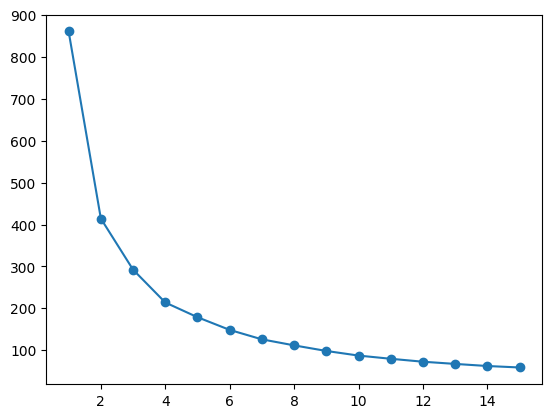

In [35]:
buscar_k_para_kmedoids(df_MMS, 16)

Como vemos por la gráfica, para el conjunto normalizado la k óptima está entre 10 y 11. Ahí el modelo comienza a converger y la inercia ya no cambia significativamente.

Ahora para el conjunto estandarizado

Punto 1 a 2 1620.558521291259
Punto 2 a 3 0.26307745883065725
Punto 3 a 4 0.6688006459262662
Punto 4 a 5 0.45204596375499084
Punto 5 a 6 0.7125772092908926
Punto 6 a 7 0.9907103560237343
Punto 7 a 8 0.8512788544264445
Punto 8 a 9 0.6291504140402829
Punto 9 a 10 1.0233941747763664
Punto 10 a 11 0.8563909124181693
Punto 11 a 12 0.8908565058167627
Punto 12 a 13 0.9139348437566931
Punto 13 a 14 0.6758011544279807
Punto 14 a 15 0.8525682708710034
Punto 15 a 16 1.0616375743803472
Punto 16 a 17 0.860500351469667
Punto 17 a 18 1.0072602327133364
Punto 18 a 19 0.8160708734937345
Punto 19 a 20 0.7703110335184143


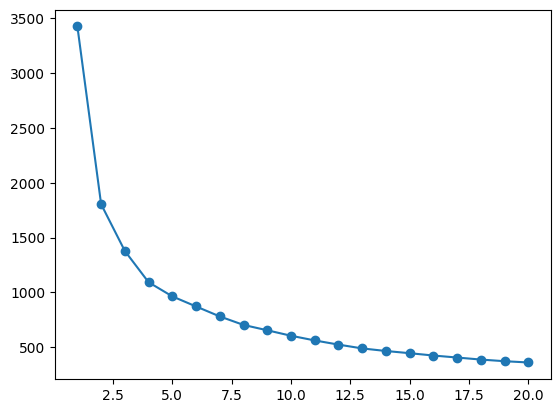

In [38]:
buscar_k_para_kmedoids(df_SS, 21)

En este caso podemos ver en la gráfica que las inercia podría seguir bajando con valor de k todavía más grandes. Sin embargo, para no perder generalidad podemos quedarnos con valores entre 14 y 15. Aplicando la regla del codo justo ahí se ve que ya no hay tanta diferencia en la inercia y los modelos convergen.

Construyamos entonces los dos modelos

In [39]:
kmedoidsMMSK = kmedoids.KMedoids(n_clusters=11, metric='euclidean', method='pam')
kmedoidsSSK = kmedoids.KMedoids(n_clusters=14, metric='euclidean', method='pam')

In [40]:
predMedoidsMMSK = prediccion(df_MMS.values, kmedoidsMMSK)

[4205 1848 4205 ... 4205 4205  275]
Inercia =  79.52323940824071


In [41]:
predMedoidsSSK = prediccion(df_SS.values, kmedoidsSSK)

[   0  865 3214 ... 3881 3214  966]
Inercia =  465.8820744263765


Calculando sus Silhouette

In [42]:
silhouette_kmedoids_MMSK = silhouette_score(df_MMS, kmedoidsMMSK.labels_, metric='euclidean')
print("Silhouette =", silhouette_kmedoids_MMSK)

Silhouette = 0.5446090747913662


In [43]:
silhouette_kmedoids_SSK = silhouette_score(df_SS, kmedoidsSSK.labels_, metric='euclidean')
print("Silhouette =", silhouette_kmedoids_SSK)

Silhouette = 0.4126168812192078


## Guardamos los modelos

In [ ]:
pickle.dump(kmeansMMSK, open("kmeansMMSK", "wb"))
pickle.dump(kmeansSSK, open("kmeansSSK", "wb"))
pickle.dump(kmedoidsMMSK, open("kmedoidsMMSK", "wb"))
pickle.dump(kmedoidsSSK, open("kmedoidsSSK", "wb"))

# 3. Comparación de los modelos

## Analizando con la inercia y silhouette de los modelos

| Algoritmo del modelo | Valor k | Transformación de los datos | Inercia | Silhouette |
| - | - | - | - | - |
| KMeans | 5 | Normalización | 13.02 | 0.6117 |
| KMeans | 8 | Estandarización | 284.81 | 0.5539 |
| KMedoids | 11 | Normalización | 79.52 | 0.5446 |
| KMedoids | 14 | Estandarización | 465.88 | 0.4126 |

Al buscar nuestro mejor modelo con base en las métricas lo primero que podemos observar es lo siguiente: para ambos algoritmos resultó mejor normalizar los datos que estandarizarlos. Esto porque en ambos modelos se tuvo que subir el valor de la k para conseguir un mejor agrupamiento para los estandarizados y aun así obtuvieron una inercia más grande y valores de silhouette más chicos.

Dado que lo que buscamos obtener es una inercia menor y un silhouette mayor con el valor menor valor de k es una inercia menor. Podríamos descartar directamente los modelos estandarizados. Esto se ve claramente en la comparación del modelo KMeans estandarizado vs el KMedoids normalizado. Si bien ambos tienen el valor silhouette casi igual, la inercia del modelo KMedoids normalizado es mucho menor que la del KMeans estandarizado. A cambio de aumentar la k de 8 a 11, KMedoids normalizado resulta una opción mucho mejor.

Ahora bien, para elegir al modelo ganador de entre los modelos normalizados, el que utiliza el algoritmo de KMeans es el mejor. A nivel de inercia es el modelo que se acercó más al cero (con amplia diferencia respecto a los demás). Con respecto al silhouette es el único modelo que superó el valor de 0.60. Y por si fuera poco, tiene una k mucho menor que la del segundo mejor modelo: 5 vs 11. Por lo tanto, a nivel de métricas el modelo con KMeans, 5 clusters y los datos normalizados, separa de mejor manera los datos de los clientes.

## Analizando con las gráficas de los resultados

Ahora bien, para hacer el análisis con gráficas vamos a utilizar la función de graficación que usamos en la práctica durante la sesión.

Esta función lo que nos permite visualizar es la separación de los k clusters de cada modelo de acuerdo a cada parámetro del conjunto de datos, es decir, de acuerdo al número de facturas, cantidad total de dinero pagada y última fecha de compra para cada usuario. El objetivo (o lo que esperamos ver) es una separación clara entre los datos de cada cluster. En este caso tenemos 4 modelos diferentes con k distintas. Por lo que nos gustaría quedarnos con el modelo con la k menor, pero que agrupe los datos de mejor manera (que en estos clusters nos queden sólo los datos que efectivamente pertenezcan al cluster).

In [46]:
def resultados(df, pred):
    df_result = df.copy()
    df_result['cluster'] = pred
    at = df_result[df_result["AmountTotal"] < 75000]
    k = at['cluster'].nunique()
    fig, axes = plt.subplots(3, 1,figsize=(16,12))
    axes[0].set_title("AmountTotal vs LastInvoice")
    axes[1].set_title("AmountTotal vs InvoiceNo")
    axes[2].set_title("LastInvoice vs InvoiceNo")
    sns.scatterplot(data=at, x=at["AmountTotal"], y=at["LastInvoice"], hue = at["cluster"], palette = sns.color_palette('hls',k), ax=axes[0])
    sns.scatterplot(data=at, x=at["AmountTotal"], y=at["InvoiceNo"], hue = at["cluster"], palette = sns.color_palette('hls',k), ax=axes[1])
    sns.scatterplot(data=at, x=at["LastInvoice"], y=at["InvoiceNo"], hue = at["cluster"], palette = sns.color_palette('hls',k), ax=axes[2])

*KMeans con los datos normalizados*

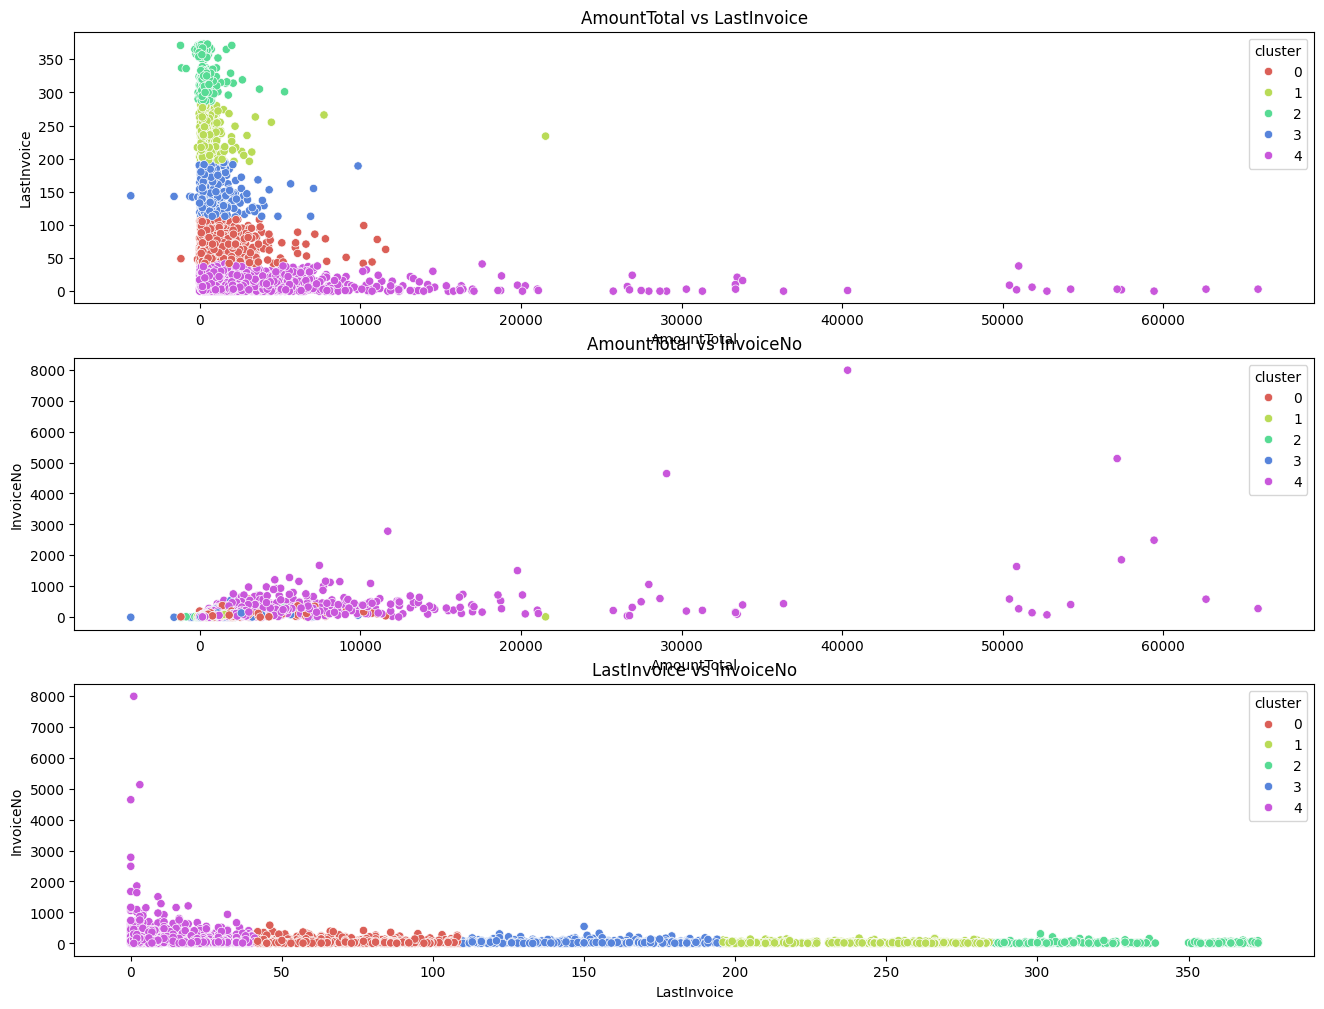

In [47]:
resultados(new_retail, predMMSK)

*KMeans con los datos estandarizados*

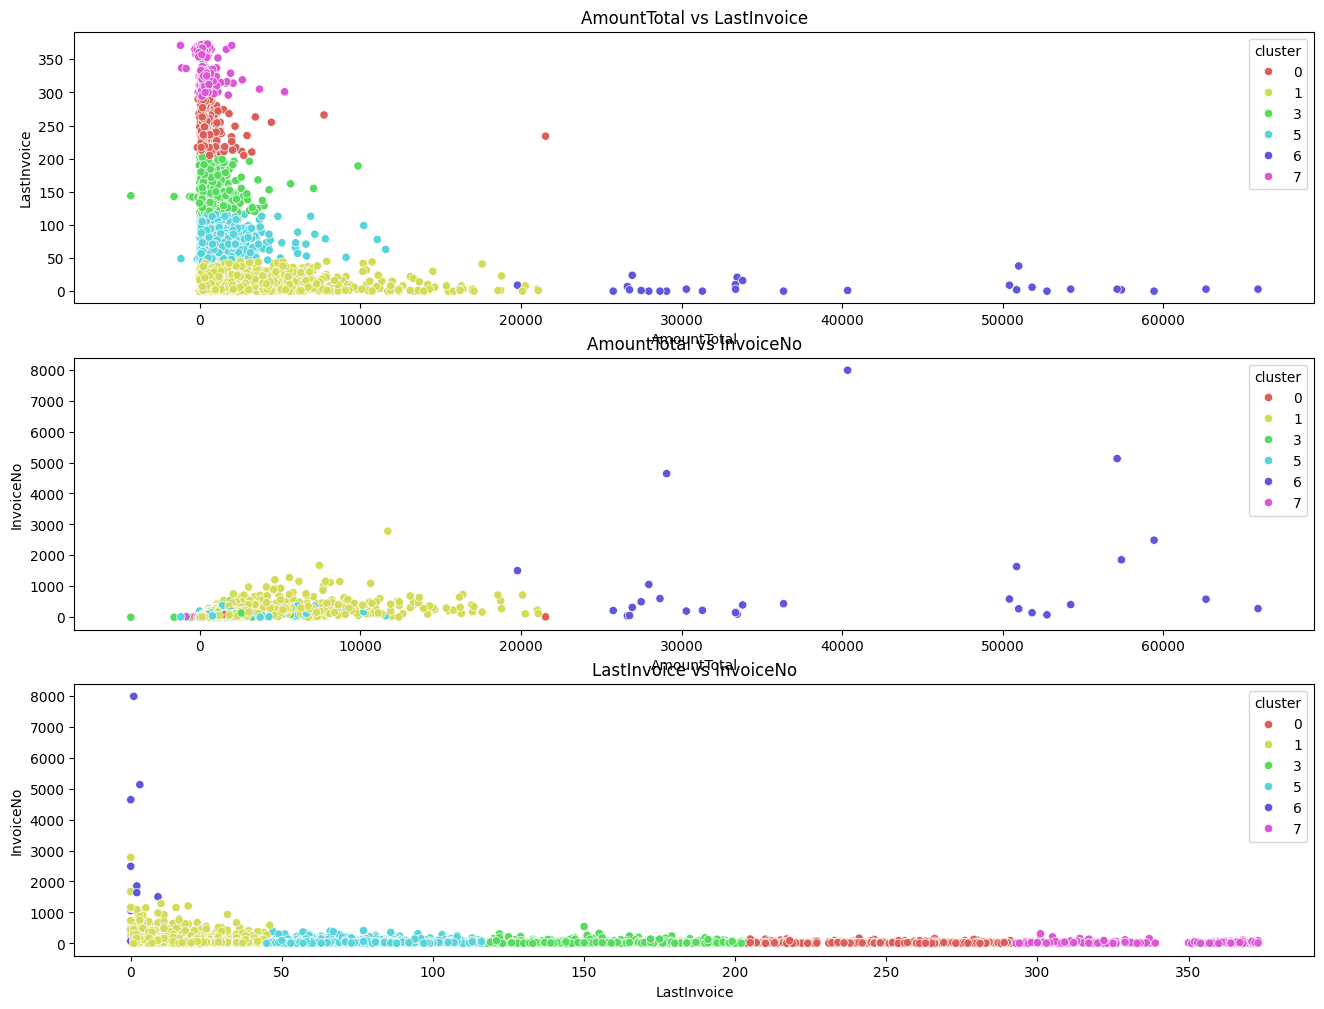

In [48]:
resultados(new_retail, predSSK)

*KMedoids con los datos normalizados*    

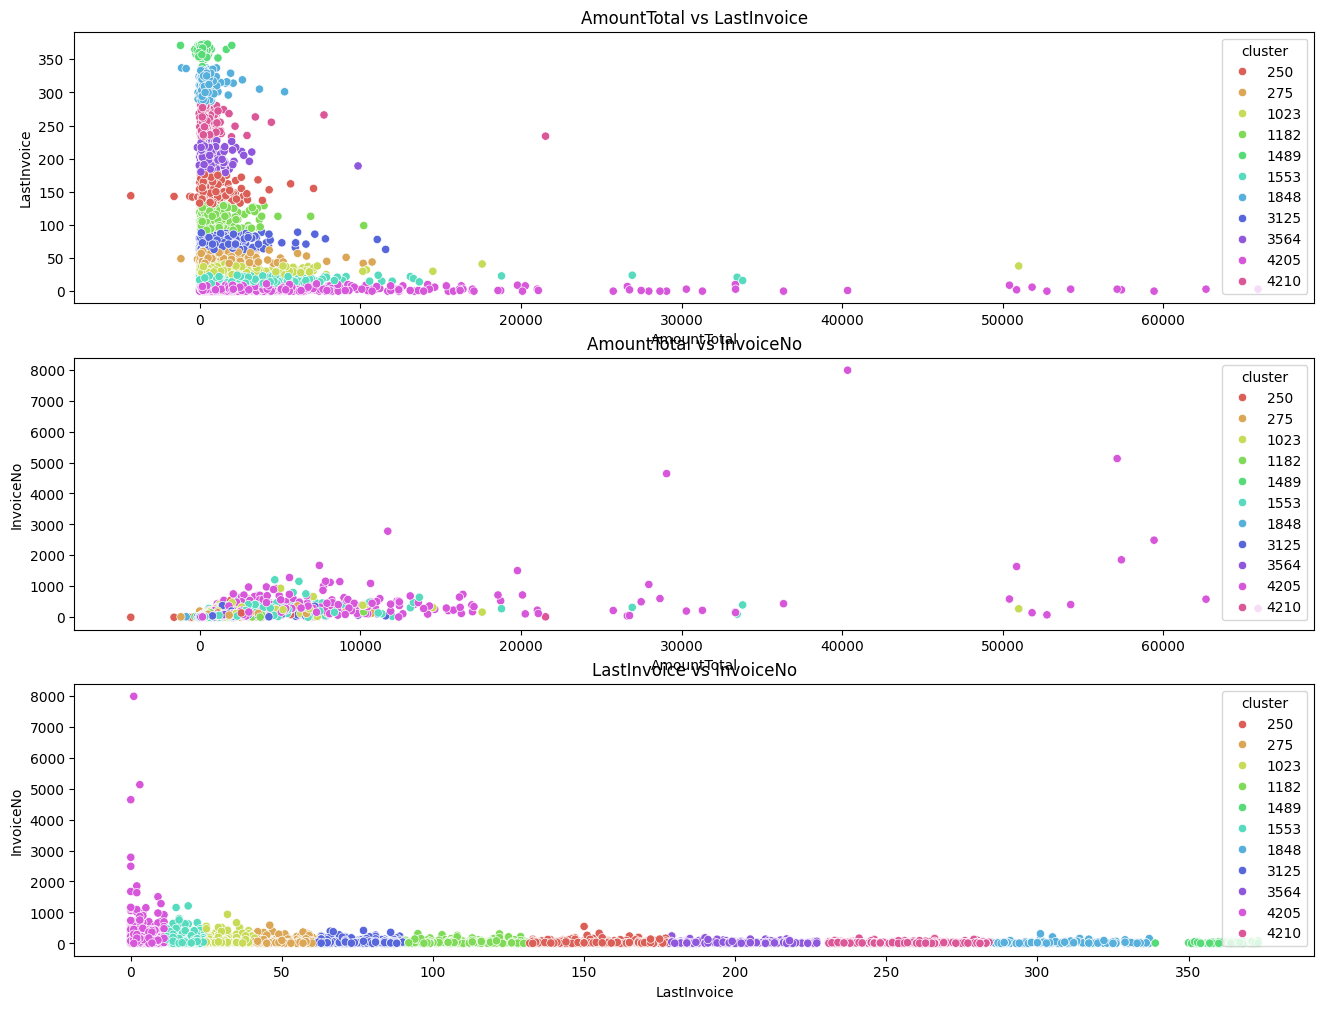

In [49]:
resultados(new_retail, predMedoidsMMSK)

*KMedoids con los datos estandarizados*

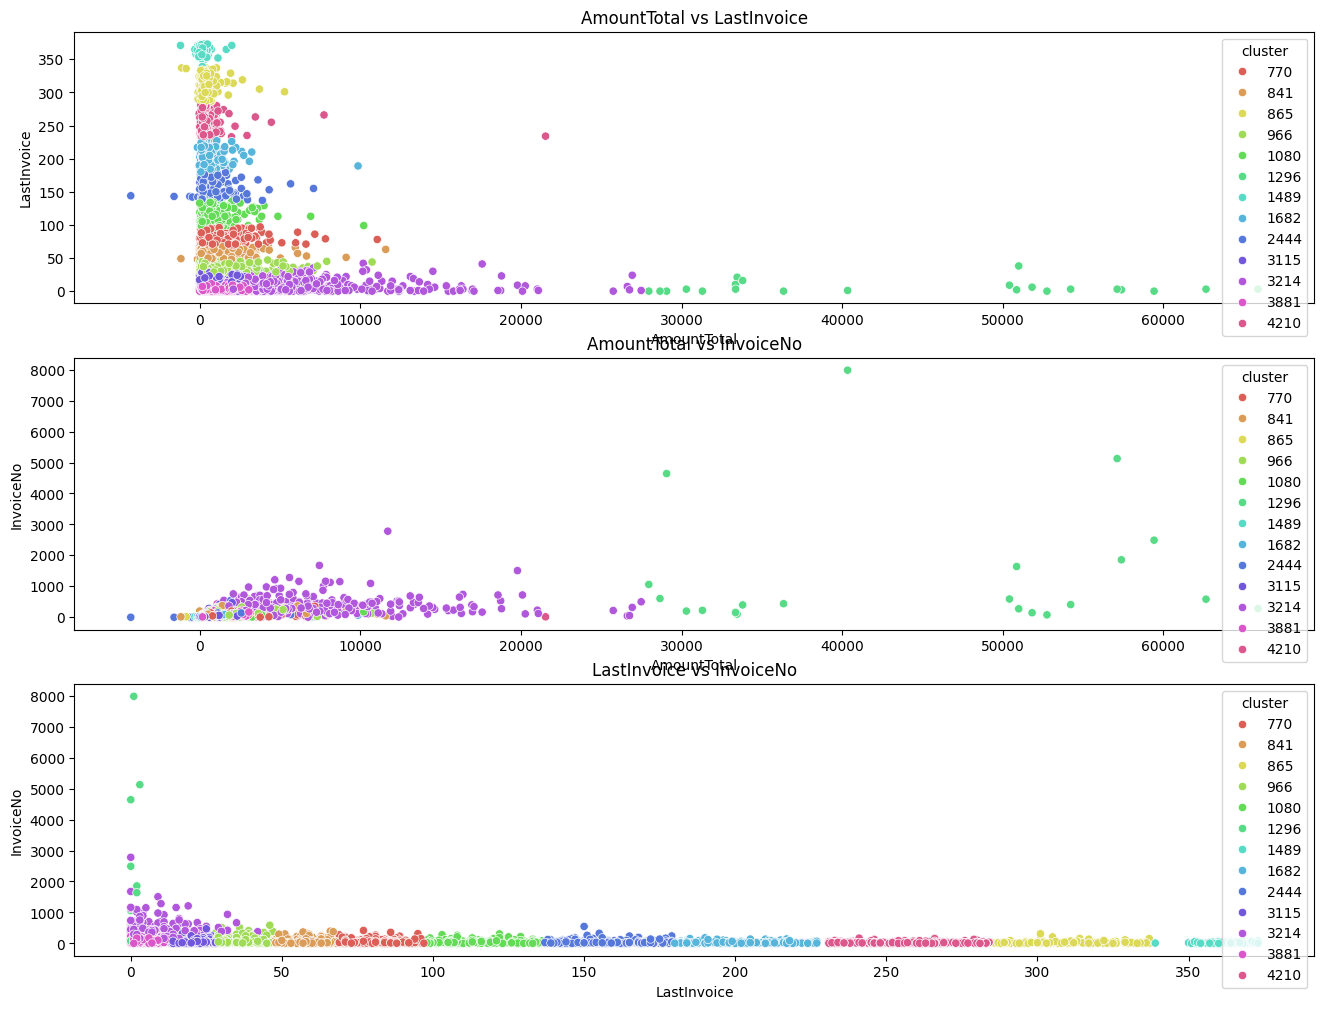

In [50]:
resultados(new_retail, predMedoidsSSK)

Lo primero que hay que resaltar es que a nivel de gráficas podemos observar mejor cómo separan los datos cada uno de los modelos.

Podemos ver en la gráfica de cantidad total de dinero vs número de factura, que es muy complicado agrupar de esta forma los datos. Aquí está el límite de estos modelos porque los 4 formaron clusters que se traslapan.

Ahora bien, en las otras dos secciones de los gráficos vemos que el crecimiento del número de clusters no implica necesariamente que queden definidos de mejor manera. Esto lo vemos sobre todo en el gráfico del modelo con Kmedoids y los datos estandarizados. Este modelo tiene muchos clusters y se traslapan mucho, sobre todo en el gráfico de última fecha de compra vs número de facturas. Justo es en estas partes donde sube la inercia y baja el silhouette. Si bien no es una regla general, en este caso particular nos serviría más que esos datos quedaran en un sólo cluster (lo cual sí se consigue en los otros 3 modelos).

Si bien a nivel de métricas llegué a la conclusión de que el modelo con KMeans normalizado era mejor. Ahora a nivel de gráficas me gustan más los modelos con KMeans estandarizado y KMedoids normalizado. Ambos modelos tienen sus grupos casi igual de definidos. Sin embargo al tener valores de k más grandes pueden aportar más información sobre los clientes de este dataset. Particularmente me quedaría con el modelo de KMeans estandarizado porque mantiene una buena separación entre cada cluster y con el número de k aporta más información por ser mayor que el del modelo normalizado. Sobre todo en las variables del número de facturas y última fecha de venta. Esto se ve con la separación de cluster en esas variables, las cuales no se verían con valores menores de la k.

# 4. Conclusiones

Trabajar con algoritmos no supervisados es un reto apasionante porque podemos encontrar nuevos patrones donde no los había. Además, resultan muy útiles porque en la práctica es difícil encontrar conjuntos de datos que estén correctamente y completamente etiquetados. De ahí que el futuro de la inteligencia artificial se encuentre en este tipo de aprendizaje.

Ahora bien, considero que hasta ahora estos son los algoritmos que he sentido más *pesados* computacionalmente hablando. Es cierto que cuando hemos hecho búsqueda en malla la computadora tardó más, pero ahí estaba realizando muchos modelos hasta encontrar la configuración de parámetros correcta. Aquí cualquier computadora tardará en hacer los cálculos en el entrenamiento si le damos una k demasiado grande. En palabras formales: los algoritmos de aprendizaje no supervisado sufren de una complejidad temporal demasiado grande.

Por otro lado, sí quisiera hacer el comentario de la diferencia en el uso entre KMeans y KMedoids. Tal vez en este conjunto de datos no pudimos ver el desempeño de KMedoids en su máximo potencial. Esto se debe a que KMedoids está hecho para cuando tenemos datos atípicos que pueden perjudicar la colocación de los centroides de cada cluster. Sin embargo, sí es una buena práctica comparar con ambos algoritmos porque no sabemos realmente en qué momento un dato atípico puede afectar nuestra agrupación.

Finalmente, hay que mencionar que el valor de k no sólo depende de obtener una buena métrica con la regla del codo en la visualización. Ya en la práctica el valor de k va a estar muy relacionado al contexto de los datos: ¿cuántos grupos quiero formar de mis datos?. Esta pregunta es clave, porque puede que la k que separa mejor los datos sea mucho menor a la k que necesito para interpretar la información y viceversa. Ahora bien, si no sabemos cuántos grupos me pueden servir para interpretar los datos, ahí sí es mejor guiarse con la inercia y silhouette. Siempre y cuando no subamos tanto la k que perdamos la generalidad que siempre buscamos al hacer machine learning.

# 5. Referencias

Además de consultar la práctica de esta sesión de aprendizaje no supervisado, se consultó la documentación de KMedoids y bibliografía básica para entender el funcionamiento del algoritmo

- https://python-kmedoids.readthedocs.io/en/latest/#
- Aggarwal, C. C. (2015). *Data Mining The Textbook.* Springer.